In [1]:
pip install keras==2.1.5

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow-gpu==1.15.0

Note: you may need to restart the kernel to use updated packages.


In [3]:
# 當電腦資源不夠時可以利用colab來進行modal的訓練
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# # 下載基於 keras 的 yolov3 程式碼
# %cd 'gdrive/My Drive'
# #!git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
# %ls

In [4]:
import os
import shutil
import numpy as np
import random
import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
import time
from timeit import default_timer as timer

# 圖像處理相關函式庫
import cv2
from PIL import Image, ImageFile, ImageFont
from yolo import YOLO

# 將 train.py 所需要的套件載入
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
# from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

import tensorflow as tf
print(tf.__version__)

#%cd keras-yolo3

if not os.path.exists("model_data/yolo.h5"):
    #print("Model doesn't exist, downloading...")
    #os.system("wget https://pjreddie.com/media/files/yolov3.weights")
    print("Converting yolov3.weights to yolo.h5...")
    os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
    print(os.getcwd())
else:
    print("Model exist")
    
#%cd ../


Using TensorFlow backend.


1.15.0
Model exist


- 定義圖像的類別

在這個圖像資料集裡有2種類別:

> - kangaroo
> - raccoon

In [5]:
# 圖像類別的Label-encoding
classes = ["kangaroo", "raccoon"]

# 取得所有圖像的圖像類別列表
labels=len(classes)

- 採隨機分配的方式，分別建置train、validation、test的資料夾，各個資料夾下包含images、annotations的資料夾，用來放相關的data

In [6]:
# copy random file to folder
print(os.getcwd())
kangaroo_path = "kangaroo-master"
raccoon_path = "raccoon-dataset-master"
train_path = "train"
validation_path = "validation"
test_path = "test"

image_path = "/images"
annotations_path = "/annotations"
annots_path = "/annots"

# 切分 train、validation、test
validation_split = 0.2
test_split = 0.2
train_split = 1

#取得所有XML檔的檔名
kangaroo_image_file = os.listdir(kangaroo_path + image_path)
kangaroo_xml_file = os.listdir(kangaroo_path + annots_path)
raccoon_image_file = os.listdir(raccoon_path + image_path)
raccoon_xml_file = os.listdir(raccoon_path + annotations_path)

C:\keras-yolo3-master


In [7]:
# 清除train、validation、test資料夾 重新創建資料夾路徑
def reset_file(path, type):
    try:
        shutil.rmtree(path)
        print("clear finish %s path ~" % type)
    except Exception as e:
        print("don't have %s path ~" % type)
    os.makedirs(path + image_path)
    os.makedirs(path + annotations_path)

reset_file(train_path, "train")
reset_file(validation_path, "validation")
reset_file(test_path, "test")

# 根據相對應的路徑抓取隨機的檔案，並複製到不同類型的資料夾下
def copy_file_to_path(file_path, images_path, type, weights):
    for i in range(round(len(images_path) * weights)):
        num = random.randint(0, len(images_path) - 1)
        images = images_path.pop(num)
        shutil.copy2(file_path + "/images/" + images, type + image_path)
        xml_file = images.replace(".jpg", ".xml")
        if file_path.count("kangaroo-master") == 1:
            shutil.copy2(file_path + "/annots/" + xml_file, type + annotations_path)
        else:
            shutil.copy2(file_path + "/annotations/" + xml_file, type + annotations_path)
    
# 分別建置train、test、validation資料夾 images、annots裡面的檔案
# kangaroo
copy_file_to_path(kangaroo_path, kangaroo_image_file, test_path, test_split)
copy_file_to_path(kangaroo_path, kangaroo_image_file, validation_path, validation_split)
copy_file_to_path(kangaroo_path, kangaroo_image_file, train_path, train_split)

# raccoon
copy_file_to_path(raccoon_path, raccoon_image_file, test_path, test_split)
copy_file_to_path(raccoon_path, raccoon_image_file, validation_path, validation_split)
copy_file_to_path(raccoon_path, raccoon_image_file, train_path, train_split)

clear finish train path ~
clear finish validation path ~
clear finish test path ~


In [8]:
train_txt = "train.txt"
test_txt = "test.txt"

#取得所有XML檔的檔名
train_xml_names = os.listdir(train_path + annotations_path)
validation_xml_names = os.listdir(validation_path + annotations_path)
test_xml_names = os.listdir(test_path + annotations_path)

# 把 annotation 轉換訓練時需要的資料形態
def convert_annotation(file, xml_file):
    in_file = open(file)
    tree=ET.parse(in_file)
    root = tree.getroot()
    for obj in root.iter("object"):
        xml_file.write(" ")
        difficult = obj.find("difficult").text
        if int(difficult) == 1:
            continue
        xmlbox = obj.find('bndbox')
        bonding = (int(xmlbox.find("xmin").text), int(xmlbox.find("ymin").text), int(xmlbox.find("xmax").text), int(xmlbox.find("ymax").text))
        xml_file.write(",".join([str(a) for a in bonding]))
        
        if obj.find("name").text == classes[0]:
            xml_file.write(",0") # kangaroo classes
        else:
            xml_file.write(",1") # raccon classes
    xml_file.write("\n")

def convert_file(file, xml_names, images_path, label_path):
    for name in xml_names:
        images = images_path + "/" + name.replace(".xml", ".jpg")
        file.write(images)
        xml = label_path + "/" + name
        convert_annotation(xml, file)


#做出以下格式的train.txt檔: image_file_path x_min,y_min,x_max,y_max,class_id
#若檔案存在需刪除 否則有error
if os.path.exists(train_txt):
    os.remove(train_txt)
    
print("train.txt isn't exists download...")

train = open(train_txt, "w")
convert_file(train, train_xml_names, train_path + image_path, train_path + annotations_path)
convert_file(train, validation_xml_names, validation_path + image_path, validation_path + annotations_path)

print("train.txt success")
train.close()

#做出以下格式的test.txt檔: image_file_path x_min,y_min,x_max,y_max,class_id
#若檔案存在需刪除 否則有error
if os.path.exists(test_txt):
    os.remove(test_txt)

print("test.txt isn't exists download...")

test = open(test_txt, "w")
convert_file(test, test_xml_names, test_path + image_path, test_path + annotations_path)

print("test.txt success")
test.close()

train.txt isn't exists download...
train.txt success
test.txt isn't exists download...
test.txt success


In [9]:
#%cd keras-yolo3
if not os.path.exists("model_data/yolo_weights.h5"):
    print("Converting pretrained YOLOv3 weights for training")
    os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")
#%cd ../

Pretrained weights exists


In [10]:
log_dir = "logs/000/" # 訓練好的模型儲存的路徑
#將voc_classes.txt內容改為 kangaroo raccoon
classes_path = "model_data/voc_classes.txt"
anchors_path = "model_data/yolo_anchors.txt"
print(os.getcwd())
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416)

is_tiny_version = len(anchors)==6 # default setting

if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path="model_data/tiny_yolo_weights.h5")
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path="model_data/yolo_weights.h5") # make sure you know what you freeze


C:\keras-yolo3-master













Create YOLOv3 model with 9 anchors and 2 classes.


C:\Users\foxlink\anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
C:\Users\foxlink\anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\foxlink\anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
C:\Users\foxlink\anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\foxlink\anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
#出現OSError: image file is truncated (8 bytes not processed)
#ref https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.2
with open(train_txt) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines) * val_split)
num_train = len(lines) - num_val

if False:
    if not os.path.exists(log_dir + 'trained_weights_stage_1.h5'):
        # Train with frozen layers first, to get a stable loss.
        # Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
        # 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
        model.compile(optimizer=Adam(lr=1e-3), loss={
            # use custom yolo_loss Lambda layer.
            'yolo_loss': lambda y_true, y_pred: y_pred})

        batch_size = 16
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                steps_per_epoch=max(1, num_train//batch_size),
                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                validation_steps=max(1, num_val//batch_size),
                epochs=50,
                initial_epoch=0,
                callbacks=[logging, checkpoint])
        model.save_weights(log_dir + 'trained_weights_stage_1.h5')
    else:
        print('Load weights')
        model = model.load_weights(log_dir + 'trained_weights_stage_1.h5') # 載入之前 train 好的權重

In [12]:
if True:
    # Unfreeze and continue training, to fine-tune.
    # Train longer if the result is not good.
    # 把所有 layer 都改為 trainable
    if not os.path.exists(log_dir + 'trained_weights_final.h5'):
        for i in range(len(model.layers)):
            model.layers[i].trainable = True
        model.compile(optimizer=Adam(lr=1e-4), loss={
            'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
        print('Unfreeze all of the layers.')

        batch_size = 4 # note that more GPU memory is required after unfreezing the body
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=100,
            initial_epoch=50,
            callbacks=[logging, checkpoint, reduce_lr, early_stopping])
        model.save_weights(log_dir + 'trained_weights_final.h5')

圖像的物體偵測
===

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (228, 96) (363, 248)
kangaroo 0.67 (127, 121) (307, 242)
3.0256393999999993


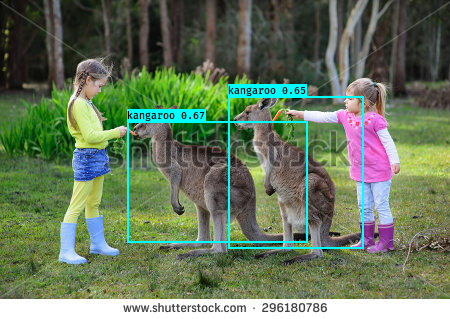

In [13]:
test = test_path + image_path
test_image_file = os.listdir(test)

# for im in test_image_file[0]:
im_path = test + "/" + test_image_file[0]
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path, anchors_path=anchors_path)
image = Image.open(im_path)
r_image = yolo_model.detect_image(image)
r_image

影像的物體偵測
===

In [14]:
# 載入訓練好的模型權重
model.load_weights(log_dir + 'trained_weights_final.h5')

# 選擇要進行浣熊影像偵測的影像檔
kangaroo_video_input = "Kangaroo.mp4"
kangaroo_video_output = "Kangaroo-out.mp4"

raccoon_video_input = "Raccoon.mp4"
raccoon_video_output = "Raccoon-out.mp4"

def video_detect(video_path, output_path):
    startTime = time.time()
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open video")
    
    # 使用 mp4v 編碼
    video_FourCC = cv2.VideoWriter_fourcc(*"mp4v")
    
    video_fps = vid.get(cv2.CAP_PROP_FPS)
    video_size = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                  int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    
    print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
    out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)

    accum_time = 0
    curr_fps = 0
    fps = "FPS: ??"
    prev_time = timer()
    while True:
        return_value, frame = vid.read()
        if return_value:
            image = Image.fromarray(frame)
            image = yolo_model.detect_image(image)
            result = np.asarray(image)
            curr_time = timer()
            exec_time = curr_time - prev_time
            prev_time = curr_time
            accum_time = accum_time + exec_time
            curr_fps = curr_fps + 1
            if accum_time > 1:
                accum_time = accum_time - 1
                fps = "FPS: " + str(curr_fps)
                curr_fps = 0
            cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.50, color=(255, 0, 0), thickness=2)
            cv2.namedWindow("Object Detect", cv2.WINDOW_NORMAL)
            cv2.resizeWindow("Object Detect", 640, 480);
            cv2.imshow("Object Detect", result)
            if True:
                print("start write...==========================================================================")
                out.write(result)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break
    out.release()
    vid.release()
    cv2.destroyAllWindows()
    
video_detect(video_path=kangaroo_video_input, output_path=kangaroo_video_output) 
video_detect(video_path=raccoon_video_input, output_path=raccoon_video_output) 

!!! TYPE: <class 'str'> <class 'int'> <class 'float'> <class 'tuple'>
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (0, 15) (663, 562)
0.04062439999999867
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48 (0, 16) (663, 561)
0.037851899999999716
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (1, 11) (657, 567)
0.03799589999999853
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.76 (2, 16) (553, 683)
0.03835799999999878
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (0, 35) (557, 656)
0.038202399999999415
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
ka

Found 0 boxes for img
0.03732880000000449
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03587070000000381
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035814999999999486
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03542809999999719
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036508900000001177
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036971499999999935
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03739060000000194
start write...=======================================================================

Found 0 boxes for img
0.036570199999999886
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.037994400000002315
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036363799999996615
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0371008000000046
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036095500000001834
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03612640000000056
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.039105700000000354
start write...======================================================================

Found 1 boxes for img
kangaroo 0.72 (574, 68) (1091, 647)
0.03926810000000103
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (573, 59) (1100, 657)
0.03731129999999894
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.68 (601, 57) (1081, 668)
0.037725399999999354
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.68 (601, 57) (1081, 669)
0.03866769999999775
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (604, 62) (1075, 659)
0.03871519999999862
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.52 (597, 51) (1082, 668)
0.03998330000000294
start write...==

start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (407, 222) (891, 673)
0.0382756999999998
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (411, 197) (889, 689)
0.037731200000003184
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (414, 163) (888, 693)
0.037549999999995975
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (406, 154) (885, 694)
0.039901300000003914
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.36 (0, 167) (918, 685)
0.03976300000000066
start write...==========================================================================
(416, 4

Found 1 boxes for img
kangaroo 0.60 (0, 46) (887, 631)
0.040801799999997
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035769500000000676
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03773060000000328
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49 (0, 0) (1280, 720)
0.040026900000000865
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (0, 0) (1280, 720)
0.041048400000001095
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (0, 9) (1124, 698)
0.03903609999999702
start write...==========================================================================
(416, 416, 

Found 1 boxes for img
kangaroo 0.72 (498, 353) (801, 630)
0.037779099999994514
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (497, 353) (798, 631)
kangaroo 0.56 (497, 353) (798, 631)
0.040097999999993306
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (459, 412) (805, 625)
0.04001949999999965
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (503, 372) (787, 620)
kangaroo 0.42 (503, 372) (787, 620)
0.042947800000000314
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (501, 388) (787, 600)
0.040664599999999496
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img


Found 1 boxes for img
kangaroo 0.33 (99, 190) (348, 407)
0.03935409999999706
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.30 (542, 209) (685, 339)
kangaroo 0.34 (100, 189) (347, 408)
0.039594200000003354
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (70, 229) (376, 413)
0.03815550000000201
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (71, 231) (388, 413)
0.038450799999999674
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (70, 230) (390, 413)
0.04001429999999573
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (69, 230) (386, 413)
0.038

Found 1 boxes for img
kangaroo 0.42 (123, 109) (311, 187)
0.039224400000001935
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035834199999996486
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035754399999994746
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03587739999999684
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03603269999999981
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03824400000000594
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03603950000000111
start write...===================================

Found 1 boxes for img
kangaroo 0.64 (918, 368) (1122, 484)
0.04072659999999928
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035952700000002835
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03635519999999559
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.038702800000002924
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.37 (1048, 392) (1159, 484)
kangaroo 0.39 (1048, 392) (1159, 484)
0.042132500000001016
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (1046, 375) (1169, 503)
kangaroo 0.36 (1046, 375) (1169, 503)
0.041962099999999225
start write...============================

Found 1 boxes for img
kangaroo 0.56 (7, 123) (161, 421)
0.03819430000000068
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.52 (8, 112) (163, 429)
0.03804010000000346
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48 (8, 109) (164, 431)
0.03868510000000214
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.51 (411, 154) (507, 382)
kangaroo 0.51 (8, 79) (159, 410)
0.03962340000000353
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (8, 74) (160, 412)
0.0394245999999967
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (8, 74) (160, 412)
0.038469499999997

Found 1 boxes for img
kangaroo 0.84 (669, 77) (1065, 681)
0.03762779999999566
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (712, 68) (1119, 694)
0.0404650999999987
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (712, 65) (1119, 697)
0.04000750000000153
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (713, 74) (1115, 686)
0.039547499999997626
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (714, 89) (1117, 669)
0.03919859999999886
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (713, 91) (1126, 673)
0.03764590000000112
start write...===

Found 3 boxes for img
kangaroo 0.54 (78, 420) (460, 551)
kangaroo 0.64 (398, 406) (727, 581)
kangaroo 0.84 (692, 345) (996, 544)
0.04530529999999544
start write...==========================================================================
(416, 416, 3)
Found 3 boxes for img
raccoon 0.33 (705, 310) (1002, 487)
kangaroo 0.53 (681, 302) (997, 548)
kangaroo 0.70 (331, 359) (716, 618)
0.04250359999999631
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.79 (349, 353) (722, 596)
kangaroo 0.88 (688, 310) (1016, 529)
0.03953469999999726
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.49 (311, 338) (745, 585)
kangaroo 0.91 (665, 320) (1045, 523)
0.04075600000000179
start write...==========================================================================
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.46 (240, 324) (657, 592)
k

start write...==========================================================================
(416, 416, 3)
Found 3 boxes for img
raccoon 0.40 (396, 309) (1053, 645)
kangaroo 0.34 (398, 318) (868, 586)
kangaroo 0.85 (71, 265) (435, 524)
0.04182260000000326
start write...==========================================================================
(416, 416, 3)
Found 3 boxes for img
raccoon 0.34 (392, 307) (1057, 647)
kangaroo 0.38 (395, 319) (867, 583)
kangaroo 0.83 (72, 267) (434, 523)
0.04135490000000175
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (115, 284) (401, 509)
0.03815550000000201
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (22, 265) (442, 594)
0.038945400000002905
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 

Found 1 boxes for img
kangaroo 0.35 (1073, 37) (1152, 311)
0.040253500000005715
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03800180000000353
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036092999999993935
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03554190000001256
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035841299999987086
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03657800000000577
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03612780000000271
start write...==================================

Found 1 boxes for img
kangaroo 0.49 (1048, 31) (1162, 311)
0.03932939999999974
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (1048, 28) (1163, 314)
0.040205799999995406
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (1048, 28) (1163, 314)
0.03975560000000655
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (1049, 30) (1162, 311)
0.039070599999988076
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.62 (1052, 27) (1161, 311)
0.040543700000000626
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (1053, 4) (1162, 332)
0.038397599999996146
start wr

Found 0 boxes for img
0.0377778999999947
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03619689999999309
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03617819999999483
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03564330000000382
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036638799999991534
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03673899999999719
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035924600000001305
start write...=========================================================================

Found 2 boxes for img
raccoon 0.90 (0, 0) (1246, 720)
kangaroo 0.34 (0, 0) (1249, 643)
0.041796400000009726
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.91 (0, 0) (1245, 720)
kangaroo 0.36 (0, 0) (1259, 643)
0.04158610000000351
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.84 (0, 0) (1248, 720)
kangaroo 0.47 (0, 0) (1240, 635)
0.042464600000002406
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.87 (0, 0) (1261, 720)
kangaroo 0.40 (0, 0) (1147, 712)
0.04237400000000946
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.83 (0, 0) (1262, 720)
kangaroo 0.55 (0, 0) (1156, 711)
0.040110399999989
start write...=======================================

Found 1 boxes for img
raccoon 0.44 (288, 121) (1015, 538)
0.04129249999999729
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03736820000000307
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03760160000000212
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035778800000002775
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03769679999999198
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03559219999999641
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03594599999999559
start write...=====================================

Found 1 boxes for img
raccoon 0.38 (0, 44) (1207, 643)
0.038331200000001786
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (4, 68) (1276, 621)
0.03836640000000102
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (113, 106) (1169, 581)
0.03815219999999897
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (113, 106) (1170, 580)
0.0373297000000008
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (101, 121) (1171, 562)
0.03902659999999969
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (56, 95) (1207, 607)
0.037877699999995684
start write...==========

Found 1 boxes for img
raccoon 0.44 (0, 62) (1269, 618)
0.04036890000000426
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (0, 58) (1239, 619)
0.03823829999998907
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (0, 73) (1280, 609)
0.03737220000000718
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (0, 81) (1280, 602)
0.03864269999999692
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.32 (0, 80) (1280, 611)
0.040397900000002096
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.32 (0, 80) (1280, 610)
0.03816260000000682
start write...====================

Found 1 boxes for img
kangaroo 0.74 (0, 8) (1176, 537)
0.04083669999999984
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.44 (0, 0) (1229, 541)
kangaroo 0.31 (0, 0) (1229, 541)
0.040782399999997665
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (0, 0) (1223, 555)
0.03793890000000033
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (0, 0) (1160, 560)
0.037939899999997806
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (0, 0) (1165, 559)
0.03869600000000162
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (0, 0) (1198, 571)
0.03767530000000363
star

Found 0 boxes for img
0.037532499999997526
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03597839999999053
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (859, 387) (953, 565)
0.03837740000000167
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.53 (851, 406) (960, 558)
0.03805889999999579
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036405199999990145
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03619790000000478
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (621, 386) (705, 560

Found 0 boxes for img
0.0394810000000092
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035657000000000494
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.037185499999992544
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0375238999999965
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036274099999999976
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03622249999999383
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03671549999999968
start write...=========================================================================

Found 0 boxes for img
0.03819599999999923
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03758140000000765
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0381263999999959
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03873640000000478
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03846419999999284
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03761039999999127
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03705349999999896
start write...==========================================================================


Found 0 boxes for img
0.039190099999999006
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.037493799999992916
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.037731399999998416
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03645129999999597
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03609790000000146
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0370610999999883
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03633810000000892
start write...========================================================================

Found 0 boxes for img
0.0375267000000008
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035796900000008236
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (0, 0) (1280, 720)
0.03790929999999548
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (0, 0) (1280, 720)
0.038519600000000764
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03616370000000302
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03608370000000605
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0362254000000064
start write...==========

Found 0 boxes for img
0.03608149999999455
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03655419999999765
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035972599999993804
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0358260999999942
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03776820000000214
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03620549999999412
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03603259999999864
start write...==========================================================================

Found 0 boxes for img
0.03791510000000642
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036708600000011415
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036427199999991444
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036409999999989395
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03683589999999981
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036266699999998764
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03637450000000797
start write...======================================================================

Found 0 boxes for img
0.03654989999999714
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03720140000000072
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035904500000000894
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03619050000000357
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03564850000000774
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035922299999995744
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0357978999999915
start write...=========================================================================

Found 0 boxes for img
0.03602779999999939
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0363168000000087
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03605979999998965
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56 (536, 187) (924, 607)
0.038066700000001674
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (536, 198) (932, 591)
0.039266300000008414
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (534, 189) (929, 596)
0.038649300000002995
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for im

Found 2 boxes for img
kangaroo 0.36 (259, 244) (503, 515)
kangaroo 0.82 (536, 173) (932, 608)
0.039569499999998925
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46 (262, 246) (499, 509)
kangaroo 0.84 (537, 178) (935, 601)
0.04093570000000568
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.72 (133, 391) (408, 601)
0.03849680000000433
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (134, 385) (402, 605)
0.03791409999999473
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (134, 385) (402, 605)
0.04043099999999811
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img


Found 2 boxes for img
kangaroo 0.41 (901, 426) (1034, 540)
kangaroo 0.69 (484, 152) (794, 622)
0.04228240000000483
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.57 (468, 157) (781, 617)
0.03871069999999577
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (468, 154) (780, 620)
0.037910800000005906
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (462, 155) (780, 615)
0.037283299999998576
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.53 (458, 145) (777, 631)
0.040373299999998835
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (800, 155) (946, 51

Found 2 boxes for img
kangaroo 0.45 (380, 279) (702, 580)
kangaroo 0.47 (781, 251) (924, 589)
0.04044910000000357
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.45 (783, 258) (920, 585)
kangaroo 0.47 (368, 278) (707, 575)
0.041172599999995896
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.58 (784, 258) (920, 582)
kangaroo 0.62 (359, 278) (717, 575)
0.039535299999997164
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.49 (783, 261) (921, 580)
kangaroo 0.57 (356, 282) (709, 575)
0.040914899999989984
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43 (783, 256) (926, 589)
kangaroo 0.66 (348, 283) (713, 582)
0.04206089999999563
start write...=

Found 0 boxes for img
0.0368440000000021
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (650, 370) (765, 570)
0.0378501
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (650, 370) (765, 570)
0.03739950000000647
start write...==========================================================================
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (650, 339) (868, 595)
kangaroo 0.39 (336, 351) (566, 556)
kangaroo 0.63 (637, 371) (773, 570)
0.04144249999998806
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.45 (330, 353) (578, 558)
kangaroo 0.72 (634, 361) (774, 591)
0.03993319999999301
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.3

start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (506, 0) (1280, 716)
0.037624000000008095
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03588809999999398
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03552729999999826
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03784450000000561
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03602449999999635
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (508, 0) (1280, 710)
0.03802559999999744
start write...===============================================

Found 1 boxes for img
kangaroo 0.84 (17, 19) (497, 669)
0.0403067999999962
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (17, 18) (499, 564)
0.038072200000002
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (16, 18) (500, 564)
0.03776630000000125
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (34, 0) (477, 588)
0.037671700000004193
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (30, 20) (488, 561)
0.040111999999993486
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (23, 23) (494, 554)
0.0375365999999957
start write...==================

Found 0 boxes for img
0.03603519999998639
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03652460000000701
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03582099999999855
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036379799999991747
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03604740000000106
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035818900000009535
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03539649999999028
start write...========================================================================

Found 0 boxes for img
0.03610919999999851
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03597789999997758
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03596930000000498
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03567319999999086
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03558759999998529
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03715060000001813
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03535379999999577
start write...==========================================================================

start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03633279999999672
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036285600000013574
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036487100000016426
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03592040000000907
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03618359999998688
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03572369999997704
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0

start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03648610000001895
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0362643999999932
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03691210000002343
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03644880000001649
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03570270000000164
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03608869999999342
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0359

start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03663339999999948
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03656300000000101
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03603010000000495
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03664639999999508
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03656050000000732
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03578260000000455
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035

Found 1 boxes for img
raccoon 0.55 (438, 0) (1255, 563)
0.03872889999999529
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035422299999993356
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03542389999998363
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036116399999997384
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03665950000001317
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03577900000001932
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03566859999997973
start write...======================================

start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.037220300000001316
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035421400000018366
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03572049999999649
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0354857000000095
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036281200000019
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03598660000000109
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoo

Found 0 boxes for img
0.03562039999999911
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03731989999999996
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.32 (372, 161) (1115, 592)
0.038926500000002306
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03620079999998893
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0360603000000026
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03589389999999071
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03628939999998693
start write...======================================

Found 0 boxes for img
0.03560519999999201
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03641179999999622
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036367000000012695
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036415399999981446
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03825970000002599
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (133, 0) (1280, 720)
0.03844970000000103
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (133, 0) (1280, 720)
0.0370785000000069
start write...=====

Found 1 boxes for img
raccoon 0.97 (107, 0) (1280, 719)
0.04006570000001375
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 0) (1280, 720)
0.03834409999998911
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 0) (1280, 720)
0.03773459999999318
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 0) (1280, 720)
0.038128000000000384
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 0) (1280, 720)
0.038295599999997876
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 0) (1280, 720)
0.03839479999999185
start write...=======================

Found 1 boxes for img
raccoon 0.60 (187, 302) (690, 665)
0.03962870000000862
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (182, 302) (685, 668)
0.03859920000002148
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (184, 300) (676, 673)
0.03800269999999273
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (185, 317) (666, 663)
0.03729509999999436
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036836199999982
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (49, 383) (806, 651)
0.03876719999999523
start write...===============================================

Found 0 boxes for img
0.03572350000001734
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03716530000002649
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03563650000000962
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0357970000000023
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0360981000000038
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03591430000000173
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03616749999997637
start write...==========================================================================
(

Found 2 boxes for img
raccoon 0.93 (0, 34) (1064, 695)
kangaroo 0.40 (0, 39) (1003, 691)
0.04172939999997993
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.94 (0, 33) (1063, 696)
kangaroo 0.38 (0, 39) (1003, 692)
0.03871919999997431
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (0, 29) (1073, 681)
0.03720999999998753
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (0, 29) (1073, 681)
0.03862720000000763
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (0, 25) (1064, 674)
0.039139799999986735
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (0, 24

Found 1 boxes for img
raccoon 0.73 (0, 0) (885, 720)
0.03963869999998337
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (0, 0) (886, 720)
0.037484199999994416
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.49 (0, 0) (873, 720)
0.03776790000000574
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (0, 0) (873, 720)
0.03802499999997622
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (11, 0) (868, 720)
0.03991380000002209
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (10, 0) (870, 720)
0.03768660000000068
start write...==============================

Found 1 boxes for img
kangaroo 0.63 (18, 321) (286, 571)
0.038489999999995916
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (19, 321) (286, 569)
0.03831410000000801
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (18, 321) (286, 568)
0.03759370000000217
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.57 (19, 320) (286, 570)
0.037767500000001064
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.30 (22, 320) (285, 570)
kangaroo 0.51 (22, 320) (285, 570)
0.04246279999998137
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.52 (24, 322) (286, 568)
0.03843

Found 1 boxes for img
kangaroo 0.33 (83, 339) (374, 579)
0.03993899999997552
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (82, 336) (376, 582)
0.038206300000013016
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (86, 336) (374, 587)
0.0382889999999918
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (93, 336) (372, 591)
0.038621599999999034
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (95, 338) (371, 588)
0.04060090000001537
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (96, 339) (369, 588)
0.03720649999999637
start write...========

Found 1 boxes for img
raccoon 0.93 (267, 0) (1069, 589)
0.04066679999999678
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (341, 69) (994, 578)
0.03777469999999994
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (307, 20) (1002, 570)
0.03783500000000117
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (321, 34) (975, 557)
0.03728190000001064
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (332, 40) (963, 552)
0.04041219999999157
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (331, 47) (957, 543)
0.03855060000000776
start write...==============

Found 1 boxes for img
raccoon 0.87 (242, 23) (1031, 554)
0.03875489999998649
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (232, 36) (1010, 542)
0.03763299999999958
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (89, 0) (1024, 602)
0.03871250000000259
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (246, 14) (999, 556)
0.0373215999999843
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (124, 0) (1001, 613)
0.038634900000005246
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (108, 0) (1004, 612)
0.037413499999985333
start write...=============

Found 1 boxes for img
raccoon 0.96 (434, 15) (1076, 501)
0.039692600000023504
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (437, 5) (1073, 508)
0.03864980000000173
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (435, 0) (1070, 514)
0.037489200000010214
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (437, 0) (1070, 526)
0.0373463999999899
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (440, 0) (1066, 522)
0.03798150000000078
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (439, 0) (1071, 528)
0.038637999999991735
start write...============

Found 1 boxes for img
raccoon 0.88 (439, 0) (1202, 625)
0.03962080000002288
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (440, 0) (1200, 626)
0.038684899999992695
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (439, 0) (1200, 625)
0.0375859000000105
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (438, 0) (1204, 626)
0.037036099999994576
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (431, 0) (1215, 631)
0.03762720000000286
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (430, 0) (1215, 624)
0.03816129999998452
start write...==============

Found 1 boxes for img
raccoon 0.97 (506, 53) (1014, 654)
0.038521599999995715
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (496, 65) (997, 625)
0.03784260000000472
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (476, 81) (972, 604)
0.03786689999998316
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (422, 53) (935, 636)
0.037939899999997806
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (423, 52) (919, 620)
0.03964030000000207
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (402, 37) (915, 626)
0.038192400000014004
start write...===========

Found 1 boxes for img
raccoon 0.57 (238, 63) (598, 694)
0.038579499999997324
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (233, 112) (600, 635)
0.03888340000000312
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.55 (240, 64) (594, 673)
kangaroo 0.37 (240, 64) (594, 673)
0.04036470000002623
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (213, 96) (618, 676)
0.038629500000013195
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (213, 116) (617, 659)
0.03907580000000621
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (216, 172) (612, 664)
0.038281

Found 1 boxes for img
raccoon 0.70 (461, 237) (859, 630)
0.038207999999997355
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (472, 230) (859, 635)
0.03796619999999962
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (440, 239) (906, 614)
0.03759230000000002
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.36 (404, 78) (933, 709)
raccoon 0.82 (514, 256) (918, 607)
0.0385432999999864
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (439, 239) (903, 623)
0.03988780000000247
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (445, 231) (900, 631)
0.0385473

Found 1 boxes for img
raccoon 0.92 (297, 220) (763, 640)
0.038811199999997825
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (302, 220) (788, 628)
0.03815919999999551
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (282, 235) (799, 609)
0.037810199999995575
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (304, 222) (789, 623)
0.03767860000002088
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (304, 206) (799, 639)
0.04046940000000632
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (305, 211) (810, 633)
0.03801029999999628
start write...=======

Found 1 boxes for img
raccoon 0.96 (385, 106) (911, 592)
0.03859910000002742
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (382, 94) (915, 621)
0.037780800000007275
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (377, 93) (942, 633)
0.03783189999998626
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (372, 105) (948, 613)
0.03871670000000904
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (363, 102) (957, 622)
0.0398721999999907
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (367, 110) (952, 616)
0.03817989999998872
start write...===========

Found 1 boxes for img
raccoon 0.92 (185, 38) (769, 720)
0.040334299999983614
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (281, 146) (750, 607)
0.037617799999992485
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (202, 51) (751, 693)
0.038253499999996166
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (301, 147) (736, 582)
0.03764929999999822
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (296, 149) (740, 588)
0.040202399999998306
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (283, 135) (754, 611)
0.03790130000001568
start write...=======

Found 1 boxes for img
raccoon 0.96 (279, 73) (956, 669)
0.03940040000000522
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (276, 69) (957, 673)
0.03818689999999947
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (282, 49) (948, 684)
0.03755529999997975
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (284, 42) (944, 682)
0.037108100000011746
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (205, 0) (939, 720)
0.04052769999998418
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (207, 0) (934, 720)
0.03804279999999949
start write...================

Found 1 boxes for img
raccoon 0.81 (32, 0) (827, 703)
0.03943369999998936
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03570460000000253
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (68, 0) (1205, 720)
0.03820310000000404
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.03811349999998015
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.03944440000000782
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (5, 0) (1260, 720)
0.03794769999998948
start write...==========================================================

Found 1 boxes for img
raccoon 0.47 (279, 398) (555, 670)
0.03778199999999288
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03586379999998712
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.30 (281, 400) (560, 662)
raccoon 0.31 (241, 385) (402, 677)
0.039839900000004036
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (236, 377) (403, 692)
0.038040100000017674
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (235, 376) (401, 691)
0.039119999999996935
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (238, 381) (400, 687)
0.037351900000004434
start write...=====

Found 0 boxes for img
0.03633109999998396
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03720739999999978
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035848000000015645
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03569000000001665
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03787490000001981
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.036009899999982053
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03572120000001178
start write...========================================================================

Found 0 boxes for img
0.038239399999980606
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (666, 335) (1001, 607)
0.03830560000000105
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035915599999981396
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.035681900000014366
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03681169999998701
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03599420000000464
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.0357795999999837
start write...====================================

Found 0 boxes for img
0.036070699999982025
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03651740000000814
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36 (37, 118) (473, 600)
0.038094999999998436
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55 (37, 129) (465, 610)
0.037752500000010514
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03601430000000505
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.037426199999998744
start write...==========================================================================
(416, 416, 3)
Found 0 boxes for img
0.03585629999997764
start write...

Found 3 boxes for img
raccoon 0.36 (543, 288) (658, 513)
kangaroo 0.37 (200, 289) (459, 672)
kangaroo 0.45 (511, 240) (655, 608)
0.04382670000001099
start write...==========================================================================
(416, 416, 3)
Found 3 boxes for img
raccoon 0.33 (543, 292) (659, 510)
kangaroo 0.39 (207, 296) (452, 662)
kangaroo 0.42 (530, 246) (666, 593)
0.04140300000000252
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (526, 253) (670, 590)
kangaroo 0.42 (105, 298) (569, 661)
0.03999919999998269
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (523, 259) (675, 580)
0.038218400000005204
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.52 (161, 297) (680, 645)
0.04042880000000082
start write...=====

Found 1 boxes for img
kangaroo 0.35 (96, 318) (630, 658)
0.04018199999998728
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (531, 257) (668, 586)
kangaroo 0.34 (95, 317) (623, 663)
0.04072850000000017
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (532, 253) (668, 589)
kangaroo 0.36 (100, 315) (614, 664)
0.03955239999999094
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (528, 255) (674, 589)
kangaroo 0.38 (97, 318) (619, 662)
0.03979849999998919
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (104, 315) (614, 664)
0.039872900000005984
start write...==========================================================================
(41

Found 1 boxes for img
kangaroo 0.69 (201, 329) (493, 636)
0.03980150000001004
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (202, 330) (493, 636)
0.038704400000000305
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.68 (201, 328) (493, 639)
0.03823449999998729
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (201, 328) (493, 639)
0.03867590000001542
start write...==========================================================================
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.68 (198, 329) (494, 638)
0.04030649999998559
start write...==========================================================================
(416, 416, 3)
Found 2 boxes for img
raccoon 0.34 (534, 275) (663, 516)
kangaroo 0.67 (201, 333) (493, 632)
0